## MGMTMFE405-2 Computational Methods in Finance
## Project 7 - Finite Difference Methods
### February 28, 2019
### Hyeuk Jung (005259560)

In [1]:
#
# Jung_Hyeuk_Project7.py
# MGMTMFE405-2 Computational Methods in Finance - Project 7
# Hyeuk Jung (005259560)
#

import random
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

np.random.seed(int(time.time()))
start = time.time()

##### Q1. European Put using Finite-Difference Method -------------------------

def bs_put(S0, T, K, r, sd):
    # d1 and d2
    d1 = (math.log(S0/K) + (r + sd*sd/2)*T) / (sd*math.sqrt(T))
    d2 = d1 - sd*math.sqrt(T)

    # put option price
    P =  K*math.exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1) 
    
    return P

def logstock_grid(S1, S2, dx, n):
    grid = np.arange(math.log(S2)+(n+1)*dx, math.log(S1)-(n+1)*dx, -dx)
    return grid

def logstock_grid2(S0, dx, n):
    grid = np.arange(math.log(s)+n*dx, math.log(S0)-(n+1)*dx, -dx)
    return grid

# Explicit FD
def explicitP(r, sd, dt, dX):
    pu = dt*( (sd*sd)/(2*dX*dX) + (r - 1/2*sd*sd)/(2*dX) )
    pm = 1 - dt*(sd*sd)/(dX*dX) - r*dt
    pd = dt*( (sd*sd)/(2*dX*dX) - (r - 1/2*sd*sd)/(2*dX) )
    return(pu, pm, pd)

def explicitA(pu, pm, pd, n):
    #array_size = n; number of rows
    PU = np.hstack( ( pu*np.identity(n - 2), np.zeros((n - 2, 2)) ) )
    PM = np.hstack( ( np.zeros((n - 2, 1)), pm*np.identity(n - 2), np.zeros((n - 2, 1)) ) )
    PD = np.hstack( ( np.zeros((n - 2, 2)), pd*np.identity(n - 2)) )
    A = PU + PM + PD
    A = np.vstack((A[0, :], A, A[-1, :])) # add first and last row to follow the description
    return A

def ExplicitFiniteDifference(type, S0, r, sd, T, dt, dX, K):
    # Initialize variables needed for the EFD calculation    
    m = int(T/dt)
    pu, pm, pd = explicitP(r, sd, dt, dX)
    logstock = logstock_grid2(S0, dX, m) #Log-stock grid; logstock = logstock_grid(S1, S2, dX, m)
    n = len(logstock)
    index_s = abs(logstock - math.log(S0)).argmin() # Finding the closest logstock index
    #index_s = [ abs(logstock - math.log(s)).argmin() for s in np.arange(4, 17, 1) ]

    A = explicitA(pu, pm, pd, n)

    if(type == "EP"):
        # Fill in the payoff at time T
        F = np.maximum(K - np.exp(logstock), 0)
        B = np.vstack( (np.zeros((n-1, 1)),  (math.exp(logstock[-1]) - math.exp(logstock[-2]))) )

        for j in range(m-1, -1, -1): # backward, column-wise loop
            F = (np.dot(A, F) - B)[0]

    return F[index_s]

# Implicit FD
def implicitP(r, sd, dt, dX):
    pu = -1/2*dt*( (sd*sd)/(dX*dX) + (r -1/2*sd*sd)/dX )
    pm = 1 + dt*(sd*sd)/(dX*dX) + r*dt
    pd = -1/2*dt*( (sd*sd)/(dX*dX) - (r -1/2*sd*sd)/dX )
    return(pu, pm, pd)

def implicitA(pu, pm, pd, n):
    #array_size = n; number of rows
    first_row = np.hstack( (1, -1, np.zeros(n - 2)) )
    PU = np.hstack( ( pu*np.identity(n - 2), np.zeros((n - 2, 2)) ) )
    PM = np.hstack( ( np.zeros((n - 2, 1)), pm*np.identity(n - 2), np.zeros((n - 2, 1)) ) )
    PD = np.hstack( ( np.zeros((n - 2, 2)), pd*np.identity(n - 2)) )
    last_row = np.hstack( (np.zeros(n - 2), 1, -1) )
    
    A = PU + PM + PD
    A = np.vstack((first_row, A, last_row)) # add first and last row to follow the description

    return A

def ImplicitFiniteDifference(type, S0, r, sd, T, dt, dX, K):
    # Initialize variables needed for the IFD calculation
    m = int(T/dt)
    pu, pm, pd = implicitP(r, sd, dt, dX)
    logstock = logstock_grid2(S0, dX, m) #Log-stock grid; logstock = logstock_grid(S1, S2, dX, m)
    n = len(logstock)
    index_s = abs(logstock - math.log(S0)).argmin() # Finding the closest logstock index
    #index_s = [ abs(logstock - math.log(s)).argmin() for s in np.arange(4, 17, 1) ]

    A = implicitA(pu, pm, pd, n)
    A_inverse = np.linalg.pinv(A)

    if(type == "EP"):
        # Fill in the payoff at time T
        F = np.maximum(K - np.exp(logstock), 0)
        B = np.hstack((0, F[1:-1], (math.exp(logstock[-1]) - math.exp(logstock[-2])) ))

        for j in range(m-1, -1, -1): # forward, column-wise loop
            F = np.dot(A_inverse, B)
            B = np.hstack((0, F[1:-1], (math.exp(logstock[-1]) - math.exp(logstock[-2])) ))

    return F[index_s]

# Crank-Nicolson FD
def CrankNicolsonP(r, sd, dt, dX):
    pu = -1/4*dt*( (sd*sd)/(dX*dX) + (r -1/2*sd*sd)/dX )
    pm = 1 + dt*(sd*sd)/(2*dX*dX) + r*dt/2
    pd = -1/4*dt*( (sd*sd)/(dX*dX) - (r -1/2*sd*sd)/dX )
    return(pu, pm, pd)

def CrankNicolsonA(pu, pm, pd, n):
    #array_size = n; number of rows
    first_row = np.hstack( (1, -1, np.zeros(n - 2)) )
    PU = np.hstack( ( pu*np.identity(n - 2), np.zeros((n - 2, 2)) ) )
    PM = np.hstack( ( np.zeros((n - 2, 1)), pm*np.identity(n - 2), np.zeros((n - 2, 1)) ) )
    PD = np.hstack( ( np.zeros((n - 2, 2)), pd*np.identity(n - 2)) )
    last_row = np.hstack( (np.zeros(n - 2), 1, -1) )
    
    A = PU + PM + PD
    A = np.vstack((first_row, A, last_row)) # add first and last row to follow the description

    return A

def CrankNicolsonFiniteDifference(type, S0, r, sd, T, dt, dX, K):
    # Initialize variables needed for the CNFD calculation
    m = int(T/dt)
    pu, pm, pd = CrankNicolsonP(r, sd, dt, dX)
    logstock = logstock_grid2(S0, dX, m) #Log-stock grid; logstock = logstock_grid(S1, S2, dX, m)
    n = len(logstock)
    index_s = abs(logstock - math.log(S0)).argmin() # Finding the closest logstock index
    #index_s = [ abs(logstock - math.log(s)).argmin() for s in np.arange(4, 17, 1) ]

    A = CrankNicolsonA(pu, pm, pd, n)
    A_inverse = np.linalg.inv(A)

    if(type == "EP"):
        # Fill in the payoff at time T
        F = np.maximum(K - np.exp(logstock), 0)
        Z = np.hstack(( -pu*F[:-2] - (pm - 2)*F[1:-1] - pd*F[2:] ))
        B = np.hstack((0, Z, (math.exp(logstock[-1]) - math.exp(logstock[-2])) ))

        for j in range(m-1, -1, -1): # central, column-wise loop
            F = np.dot(A_inverse, B)  
            Z = np.hstack(( -pu*F[:-2] - (pm - 2)*F[1:-1] - pd*F[2:] ))
            B = np.hstack((0, Z, (math.exp(logstock[-1]) - math.exp(logstock[-2])) ))

    return F[index_s]


S0 = 10; sd = 0.2; r = 0.04; dt = 0.002; dX = [sd*math.sqrt(dt), sd*math.sqrt(3*dt), sd*math.sqrt(4*dt)]
K = 10; T = 0.5; S = np.arange(4, 17, 1)

BS_put = [ bs_put(s, T, K, r, sd) for s in S]

explicit = dict()
for s in S:
    explicit[(s)] = [ExplicitFiniteDifference("EP", s, r, sd, T, dt, dx, K) for dx in dX]
df_explicit = pd.concat([pd.DataFrame(list(explicit.keys())), pd.DataFrame(list(explicit.values())), pd.DataFrame(BS_put)], axis=1)
df_explicit.columns = ['S0', 'dX1 = sd*sqrt(dt)', 'dX2 = sd*sqrt(3*dt)', 'dX3 = sd*sqrt(4*dt)', 'BS_put'] # print(df_result_02)
df_explicit['Error_dX1'] = (abs(df_explicit['dX1 = sd*sqrt(dt)'] - df_explicit['BS_put'])).astype(float)
df_explicit['Error_dX2'] = (abs(df_explicit['dX2 = sd*sqrt(3*dt)'] - df_explicit['BS_put'])).astype(float)
df_explicit['Error_dX3'] = (abs(df_explicit['dX3 = sd*sqrt(4*dt)'] - df_explicit['BS_put'])).astype(float)
print('Explicit Finite Difference Method - European Put:\n', df_explicit)

implicit = dict()
for s in S:
    implicit[(s)] = [ImplicitFiniteDifference("EP", s, r, sd, T, dt, dx, K) for dx in dX]
df_implicit = pd.concat([pd.DataFrame(list(implicit.keys())), pd.DataFrame(list(implicit.values())), pd.DataFrame(BS_put)], axis=1)
df_implicit.columns = ['S0', 'dX1 = sd*sqrt(dt)', 'dX2 = sd*sqrt(3*dt)', 'dX3 = sd*sqrt(4*dt)', 'BS_put'] # print(df_result_02)
df_implicit['Error_dX1'] = (abs(df_implicit['dX1 = sd*sqrt(dt)'] - df_implicit['BS_put'])).astype(float)
df_implicit['Error_dX2'] = (abs(df_implicit['dX2 = sd*sqrt(3*dt)'] - df_implicit['BS_put'])).astype(float)
df_implicit['Error_dX3'] = (abs(df_implicit['dX3 = sd*sqrt(4*dt)'] - df_implicit['BS_put'])).astype(float)
print('Implicit Finite Difference Method - European Put:\n', df_implicit)

cranknicolson = dict()
for s in S:
    cranknicolson[(s)] = [CrankNicolsonFiniteDifference("EP", s, r, sd, T, dt, dx, K) for dx in dX]
df_cranknicolson = pd.concat([pd.DataFrame(list(cranknicolson.keys())), pd.DataFrame(list(cranknicolson.values())), pd.DataFrame(BS_put)], axis=1)
df_cranknicolson.columns = ['S0', 'dX1 = sd*sqrt(dt)', 'dX2 = sd*sqrt(3*dt)', 'dX3 = sd*sqrt(4*dt)', 'BS_put'] # print(df_result_02)
df_cranknicolson['Error_dX1'] = (abs(df_cranknicolson['dX1 = sd*sqrt(dt)'] - df_cranknicolson['BS_put'])).astype(float)
df_cranknicolson['Error_dX2'] = (abs(df_cranknicolson['dX2 = sd*sqrt(3*dt)'] - df_cranknicolson['BS_put'])).astype(float)
df_cranknicolson['Error_dX3'] = (abs(df_cranknicolson['dX3 = sd*sqrt(4*dt)'] - df_cranknicolson['BS_put'])).astype(float)
print('Crank-Nicolson Finite Difference Method - European Put:\n', df_cranknicolson)



Explicit Finite Difference Method - European Put:
     S0  dX1 = sd*sqrt(dt)  dX2 = sd*sqrt(3*dt)  dX3 = sd*sqrt(4*dt)    BS_put  \
0    4           5.801978             5.801976             5.801976  5.801987   
1    5           4.801978             4.801976             4.801975  4.801987   
2    6           3.802045             3.802046             3.802048  3.802058   
3    7           2.805270             2.805322             2.805350  2.805357   
4    8           1.844271             1.844339             1.844436  1.844269   
5    9           1.024218             1.024418             1.024181  1.024428   
6   10           0.464126             0.464153             0.463878  0.464695   
7   11           0.171822             0.171445             0.171668  0.171537   
8   12           0.052408             0.052486             0.052447  0.052460   
9   13           0.013641             0.013600             0.013724  0.013651   
10  14           0.003071             0.003115            

All finite difference methods' results are close to the theoretical values. For the Explicit Finite Difference Method, dX = sd*sqrt(3*dt) returns the most accurate result, which corresponds to the convergence condition. However, results with dX = sd*sqrt(4*dt) are less accurate compared to the dX = sd*sqrt(dt). Implicit Finite Difference Method's results show the largest error size, especially in ATM status, though the error values are very small.
The most accurate results are obtained from the Crank-Nicolson Finite Difference Method. 

In [2]:
##### Q2. American Call/Put using Finite-Difference Method --------------------
def stock_grid(S1, S2, ds, n):
    grid = np.arange( S2+(n+1)*ds, S1-(n+1)*ds, -ds )
    return grid

def stock_grid2(S0, ds, n):
    # Setting the lower boundary to be zero (reflecting the stock price characteristic)
    grid = np.arange( S0 + n*ds, 0-ds, -ds  )
    return grid

# Generalized FD
def generalized_ab(r, sd, dt, dS, alpha, n):
    # j = number of row (a.k.a. stock grid length)
    j = np.arange(1, n-1, 1) 
    # remove boundary rows so that I can assign them in generalized_AB function
    # in the case with j = 0, a1 and b1 returns zero --> don't need these cases
    a1 = (sd*sd*j*j - r*j)*(1 - alpha) / 2
    a2 = -1/dt - (sd*sd*j*j + r)*(1 - alpha)
    a3 = (sd*sd*j*j + r*j)*(1 - alpha) / 2

    b1 = (sd*sd*j*j - r*j)*alpha / 2
    b2 = 1/dt - (sd*sd*j*j + r)*alpha
    b3 = (sd*sd*j*j + r*j)*alpha / 2

    return(a1, a2, a3, b1, b2, b3)

def generalized_AB(a1, a2, a3, b1, b2, b3, n):
    #array_size = n
    # A 
    A_first_row = np.hstack( (a2[0], a3[0], np.zeros(n - 2)) )
    A1 = np.hstack( ( np.diag(a1), np.zeros((n - 2, 2)) ) )
    A2 = np.hstack( ( np.zeros((n - 2, 1)), np.diag(a2), np.zeros((n - 2, 1)) ) )
    A3 = np.hstack( ( np.zeros((n - 2, 2)), np.diag(a3) ) )
    A_last_row = np.hstack( (np.zeros(n - 2), a1[-1], a2[-1]) )
    A = A1 + A2 + A3

    # B: b1~b3 needs a negative sign
    B_first_row = np.hstack( (-b2[0], -b3[0], np.zeros(n - 2)) )
    B1 = np.hstack(( np.diag(-b1), np.zeros((n - 2, 2)) ))
    B2 = np.hstack(( np.zeros((n - 2, 1)), np.diag(-b2), np.zeros((n - 2, 1)) ))
    B3 = np.hstack(( np.zeros((n - 2, 2)), np.diag(-b3) ))
    B_last_row = np.hstack( (np.zeros(n - 2), -b1[-1], -b2[-1]) )
    B = B1 + B2 + B3

    A = np.vstack(( A_first_row, A, A_last_row ))
                   # add first and last row to follow the description
    B = np.vstack(( B_first_row, B, B_last_row )) 
    #np.hstack( (-B2[0], -B3[0], np.zeros(n-2)) )
    #np.hstack( (np.zeros(n-2), -B1[-1], -B2[-1])
    return A, B

def GeneralizedFD(type, S0, r, sd, T, dt, dS, K, alpha):
    # alpha = 1 --> explicit
    # alpha ≠ 1 --> implicit 
    # alpha = 0 --> fully implicit
    # alpha = 1/2 --> crank-nicolson
    
    # Initialize variables needed for the calculation
    m = int(T/dt) # Column size --> number of calculation
    stock = stock_grid2(S0, dS, int(S0/dS)) # Stock grid --> length will be the number of rows
    n = len(stock)
    a1, a2, a3, b1, b2, b3 = generalized_ab(r, sd, dt, dS, alpha, n)
    A, B = generalized_AB(a1, a2, a3, b1, b2, b3, n)
    A_inverse = np.linalg.inv(A)

    # Finding the closest stock index
    index_s = abs(stock - S0).argmin()

    # American Call
    if(type == "AC"):
        F = np.maximum(stock - K , 0)
        for j in range(m-1, -1, -1):
            F_candidate = np.dot(A_inverse, np.dot(B, F)) # F candidate for time i
            F = np.maximum(F_candidate, F) # F candidate vs. F at time i+1

    # American Put
    elif(type == "AP"):
        F = np.maximum(K - stock, 0)
        for j in range(m-1, -1, -1):
            F_candidate = np.dot(A_inverse, np.dot(B, F)) # F candidate for time i
            F = np.maximum(F_candidate, F) # F candidate vs. F at time i+1
    
    else: print('ERROR: Choose proper option type.') 

    return F[index_s]


S0 = 10; sd = 0.2; r = 0.04; dt = 0.002 ; dS = [0.25, 1, 1.25]
K = 10; T = 0.5; S = np.arange(4, 17, 1)

alpha = 1
e_generalized_call = dict()
for s in S:
    e_generalized_call[(s)] = [GeneralizedFD("AC", s, r, sd, T, dt, ds, K, alpha) for ds in dS]
df_e_generalized_call = pd.concat([pd.DataFrame(list(e_generalized_call.keys())), pd.DataFrame(list(e_generalized_call.values()))], axis=1)
df_e_generalized_call.columns = ['S0', 'dS = 0.25', 'dS = 1', 'dS = 1.25'] 
print('Explicit Finite Difference Method - American Call:\n', df_e_generalized_call)

e_generalized_put = dict()
for s in S:
    e_generalized_put[(s)] = [GeneralizedFD("AP", s, r, sd, T, dt, ds, K, alpha) for ds in dS]
df_e_generalized_put = pd.concat([pd.DataFrame(list(e_generalized_put.keys())), pd.DataFrame(list(e_generalized_put.values()))], axis=1)
df_e_generalized_put.columns = ['S0', 'dS = 0.25', 'dS = 1', 'dS = 1.25'] 
print('Explicit Finite Difference Method - American Put:\n', df_e_generalized_put)
   

alpha = 0
i_generalized_call = dict()
for s in S:
    i_generalized_call[(s)] = [GeneralizedFD("AC", s, r, sd, T, dt, ds, K, alpha) for ds in dS]
df_i_generalized_call = pd.concat([pd.DataFrame(list(i_generalized_call.keys())), pd.DataFrame(list(i_generalized_call.values()))], axis=1)
df_i_generalized_call.columns = ['S0', 'dS = 0.25', 'dS = 1', 'dS = 1.25'] 
print('Implicit Finite Difference Method - American Call:\n', df_i_generalized_call)

i_generalized_put = dict()
for s in S:
    i_generalized_put[(s)] = [GeneralizedFD("AP", s, r, sd, T, dt, ds, K, alpha) for ds in dS]
df_i_generalized_put = pd.concat([pd.DataFrame(list(i_generalized_put.keys())), pd.DataFrame(list(i_generalized_put.values()))], axis=1)
df_i_generalized_put.columns = ['S0', 'dS = 0.25', 'dS = 1', 'dS = 1.25'] 
print('Implicit Finite Difference Method - American Put:\n', df_i_generalized_put)


alpha = 1/2
cn_generalized_call = dict()
for s in S:
    cn_generalized_call[(s)] = [GeneralizedFD("AC", s, r, sd, T, dt, ds, K, alpha) for ds in dS]
df_cn_generalized_call = pd.concat([pd.DataFrame(list(cn_generalized_call.keys())), pd.DataFrame(list(cn_generalized_call.values()))], axis=1)
df_cn_generalized_call.columns = ['S0', 'dS = 0.25', 'dS = 1', 'dS = 1.25'] 
print('Crank-Nicolson Finite Difference Method - American Call:\n', df_cn_generalized_call)

cn_generalized_put = dict()
for s in S:
    cn_generalized_put[(s)] = [GeneralizedFD("AP", s, r, sd, T, dt, ds, K, alpha) for ds in dS]
df_cn_generalized_put = pd.concat([pd.DataFrame(list(cn_generalized_put.keys())), pd.DataFrame(list(cn_generalized_put.values()))], axis=1)
df_cn_generalized_put.columns = ['S0', 'dS = 0.25', 'dS = 1', 'dS = 1.25'] 
print('Crank-Nicolson Finite Difference Method - American Put:\n', df_cn_generalized_put)


Explicit Finite Difference Method - American Call:
     S0     dS = 0.25        dS = 1     dS = 1.25
0    4  0.000000e+00  0.000000e+00  0.000000e+00
1    5  0.000000e+00  0.000000e+00  0.000000e+00
2    6  2.253992e-12  5.126260e-08  8.913718e-24
3    7  6.755937e-06  7.573230e-05  1.382334e-04
4    8  5.150583e-03  5.846557e-03  1.045956e-02
5    9  1.051044e-01  8.776293e-02  1.035773e-01
6   10  4.806638e-01  4.399789e-01  4.153277e-01
7   11  1.150342e+00  1.126069e+00  1.089700e+00
8   12  2.018415e+00  2.001965e+00  2.000000e+00
9   13  3.000000e+00  3.000000e+00  3.000000e+00
10  14  4.000000e+00  4.000000e+00  4.000000e+00
11  15  5.000000e+00  5.000000e+00  5.000000e+00
12  16  6.000000e+00  6.000000e+00  6.000000e+00
Explicit Finite Difference Method - American Put:
     S0  dS = 0.25    dS = 1  dS = 1.25
0    4   6.000000  6.000000   6.000000
1    5   5.000000  5.000000   5.000000
2    6   4.039604  4.039604   4.019802
3    7   3.079215  3.079282   3.064493
4    8   2.12388

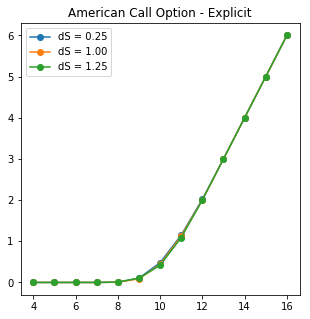

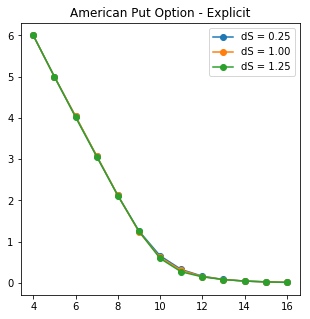

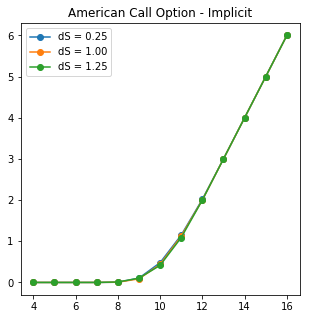

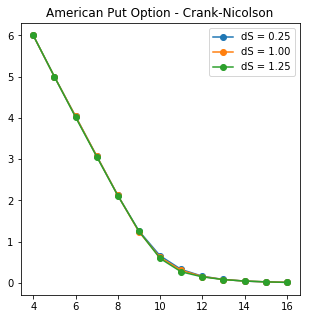

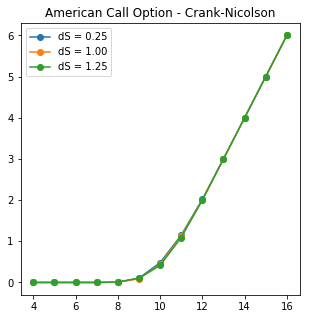

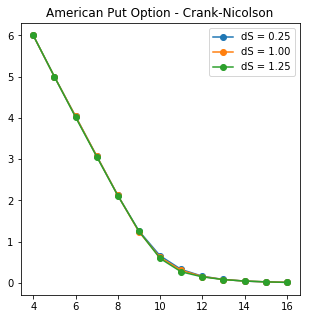

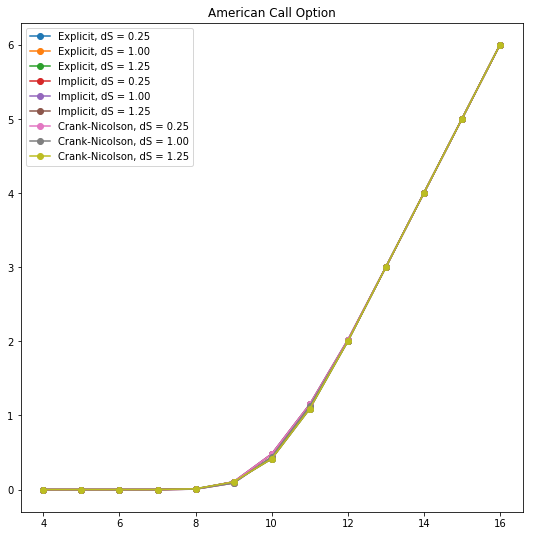

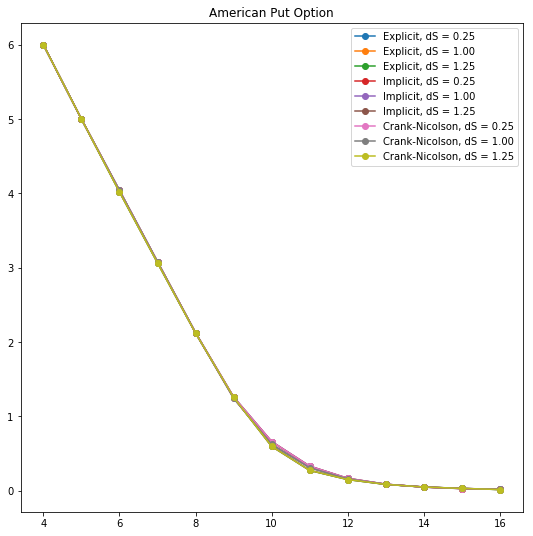

Total execution time: 23.10627770423889


In [3]:
# Explicit FD Plots
plt.figure(figsize=(5,5))
plt.plot(S, df_e_generalized_call['dS = 0.25'], label = 'dS = 0.25', marker = 'o')
plt.plot(S, df_e_generalized_call['dS = 1'], label = 'dS = 1.00', marker = 'o')
plt.plot(S, df_e_generalized_call['dS = 1.25'], label = 'dS = 1.25', marker = 'o')
plt.legend()
plt.title('American Call Option - Explicit')
plt.show()

plt.figure(figsize=(5,5))
plt.plot(S, df_e_generalized_put['dS = 0.25'], label = 'dS = 0.25', marker = 'o')
plt.plot(S, df_e_generalized_put['dS = 1'], label = 'dS = 1.00', marker = 'o')
plt.plot(S, df_e_generalized_put['dS = 1.25'], label = 'dS = 1.25', marker = 'o')
plt.legend()
plt.title('American Put Option - Explicit')
plt.show()

# Implicit FD Plots
plt.figure(figsize=(5,5))
plt.plot(S, df_i_generalized_call['dS = 0.25'], label = 'dS = 0.25', marker = 'o')
plt.plot(S, df_i_generalized_call['dS = 1'], label = 'dS = 1.00', marker = 'o')
plt.plot(S, df_i_generalized_call['dS = 1.25'], label = 'dS = 1.25', marker = 'o')
plt.legend()
plt.title('American Call Option - Implicit')
plt.show()

plt.figure(figsize=(5,5))
plt.plot(S, df_cn_generalized_put['dS = 0.25'], label = 'dS = 0.25', marker = 'o')
plt.plot(S, df_cn_generalized_put['dS = 1'], label = 'dS = 1.00', marker = 'o')
plt.plot(S, df_cn_generalized_put['dS = 1.25'], label = 'dS = 1.25', marker = 'o')
plt.legend()
plt.title('American Put Option - Crank-Nicolson')
plt.show()

# Crank-Nicolson FD Plots
plt.figure(figsize=(5,5))
plt.plot(S, df_cn_generalized_call['dS = 0.25'], label = 'dS = 0.25', marker = 'o')
plt.plot(S, df_cn_generalized_call['dS = 1'], label = 'dS = 1.00', marker = 'o')
plt.plot(S, df_cn_generalized_call['dS = 1.25'], label = 'dS = 1.25', marker = 'o')
plt.legend()
plt.title('American Call Option - Crank-Nicolson')
plt.show()

plt.figure(figsize=(5,5))
plt.plot(S, df_cn_generalized_put['dS = 0.25'], label = 'dS = 0.25', marker = 'o')
plt.plot(S, df_cn_generalized_put['dS = 1'], label = 'dS = 1.00', marker = 'o')
plt.plot(S, df_cn_generalized_put['dS = 1.25'], label = 'dS = 1.25', marker = 'o')
plt.legend()
plt.title('American Put Option - Crank-Nicolson')
plt.show()


# Combined Plots 
plt.figure(figsize=(9,9))
plt.plot(S, df_e_generalized_call['dS = 0.25'], label = 'Explicit, dS = 0.25', marker = 'o')
plt.plot(S, df_e_generalized_call['dS = 1'], label = 'Explicit, dS = 1.00', marker = 'o')
plt.plot(S, df_e_generalized_call['dS = 1.25'], label = 'Explicit, dS = 1.25', marker = 'o')
plt.plot(S, df_i_generalized_call['dS = 0.25'], label = 'Implicit, dS = 0.25', marker = 'o')
plt.plot(S, df_i_generalized_call['dS = 1'], label = 'Implicit, dS = 1.00', marker = 'o')
plt.plot(S, df_i_generalized_call['dS = 1.25'], label = 'Implicit, dS = 1.25', marker = 'o')
plt.plot(S, df_cn_generalized_call['dS = 0.25'], label = 'Crank-Nicolson, dS = 0.25', marker = 'o')
plt.plot(S, df_cn_generalized_call['dS = 1'], label = 'Crank-Nicolson, dS = 1.00', marker = 'o')
plt.plot(S, df_cn_generalized_call['dS = 1.25'], label = 'Crank-Nicolson, dS = 1.25', marker = 'o')
plt.legend()
plt.title('American Call Option')
plt.show()

plt.figure(figsize=(9,9))
plt.plot(S, df_e_generalized_put['dS = 0.25'], label = 'Explicit, dS = 0.25', marker = 'o')
plt.plot(S, df_e_generalized_put['dS = 1'], label = 'Explicit, dS = 1.00', marker = 'o')
plt.plot(S, df_e_generalized_put['dS = 1.25'], label = 'Explicit, dS = 1.25', marker = 'o')
plt.plot(S, df_i_generalized_put['dS = 0.25'], label = 'Implicit, dS = 0.25', marker = 'o')
plt.plot(S, df_i_generalized_put['dS = 1'], label = 'Implicit, dS = 1.00', marker = 'o')
plt.plot(S, df_i_generalized_put['dS = 1.25'], label = 'Implicit, dS = 1.25', marker = 'o')
plt.plot(S, df_cn_generalized_put['dS = 0.25'], label = 'Crank-Nicolson, dS = 0.25', marker = 'o')
plt.plot(S, df_cn_generalized_put['dS = 1'], label = 'Crank-Nicolson, dS = 1.00', marker = 'o')
plt.plot(S, df_cn_generalized_put['dS = 1.25'], label = 'Crank-Nicolson, dS = 1.25', marker = 'o')
plt.legend()
plt.title('American Put Option')
plt.show()

total_execution = time.time() - start
print('Total execution time:', total_execution)
